In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import numpy as np

import matplotlib.pyplot as plt

from time import time
from IPython.display import clear_output

In [2]:
#dataset = torchvision.datasets.MNIST(root='./data/', download=True, transform=torchvision.transforms.Compose([
#                               torchvision.transforms.ToTensor(),
#                               torchvision.transforms.Normalize(
#                                 (0.5), (0.5))
#                             ]))
dataset = torchvision.datasets.CIFAR100(root='./data/', download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ]))
print(len(dataset))

Files already downloaded and verified
50000


In [3]:
BATCH_SIZE = 64
TRAIN_RATIO = 0.5

In [4]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(TRAIN_RATIO * len(dataset)), len(dataset) - int(TRAIN_RATIO * len(dataset))])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
class ModelTrainer:
    def __init__(self, train_generator, test_generator):
        self.__model = None
        self.__train_generator = train_generator
        self.__test_generator = test_generator

    def set_model(self, model, model_name='model'):
        self.__model = model
        self.__model_name = model_name

    def get_model(self):
        return self.__model

    def get_model_name(self):
        return self.__model_name
    
    def train_epoch(self, optimizer, batch_size=32, cuda=True, with_watermark=False):
        assert self.__model is not None
        
        model = self.__model

        loss_log, acc_log = [], []
        model.train()
        steps = 0
        for batch_num, (x_batch, y_batch) in enumerate(self.__train_generator):
            data = x_batch.cuda() if cuda else x_batch
            target = y_batch.cuda() if cuda else y_batch

            optimizer.zero_grad()
            output = model(data)
            pred = torch.max(output, 1)[1].cpu()
            acc = torch.eq(pred, y_batch).float().mean()
            acc_log.append(acc)
            
            loss = F.nll_loss(output, target)
            if with_watermark:
                loss += self.get_watermark_loss()
    
            loss.backward()
            optimizer.step()
            loss = loss.cpu().item()
            loss_log.append(loss)
            
            steps += 1
            print('Step {0}'.format(steps), flush=True, end='\r')

        return loss_log, acc_log, steps
        
    def set_watermark(self, message):
        self.__message = message
        message_size = message.shape[0]
        self.__key = torch.normal(torch.zeros(message_size, message_size), torch.ones(message_size, message_size))
    
    def get_watermark(self):
        return self.__message

    def get_key(self):
        return self.__key
    
    def predict_watermark(self, logits=False):
        params = []
        for layer in self.__model[1:]:
            if isinstance(layer, nn.Conv2d):
                params.append(layer.weight)
        params = torch.cat(params, dim=0).mean(dim=0)
        w = params.view(-1)[:self.__message.shape[0]]
        message_pred = torch.matmul(self.__key.to(w.device), w)
        if logits:
            return message_pred
        else:
            return (message_pred >= 0).to(torch.float32)
        
    
    def get_watermark_loss(self, cuda=False):
        
        message_pred = self.predict_watermark(logits=True)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(message_pred, self.__message.to(message_pred.device))
        return loss
        

    def train(self, n_epochs, batch_size=32, lr=1e-3, cuda=True, plot_history=None, clear_output=None, with_watermark=False):
        assert self.__model is not None
    
        if cuda:
            self.__model = self.__model.cuda()
        else:
            self.__model = self.__model.cpu()

        model = self.__model
        #opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-2, momentum=0.5)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        train_log, train_acc_log = [], []
        val_log, val_acc_log = [], []

        best_val_score = 0.

        for epoch in range(n_epochs):
            epoch_begin = time()
            print("Epoch {0} of {1}".format(epoch, n_epochs))
            train_loss, train_acc, steps = self.train_epoch(opt, batch_size=batch_size, cuda=cuda, with_watermark=with_watermark)

            val_loss, val_acc = self.test(cuda=cuda)

            train_log.extend(train_loss)
            train_acc_log.extend(train_acc)

            val_log.append((steps * (epoch + 1), np.mean(val_loss)))
            val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

            if np.mean(val_acc) > best_val_score:
                best_val_score = np.mean(val_acc)
                torch.save(model, self.__model_name + '_best.pth')
            
            if plot_history is not None:
                clear_output()
                plot_history(train_log, val_log)
                plot_history(train_acc_log, val_acc_log, title='accuracy')   
            epoch_end = time()
            epoch_time = epoch_end - epoch_begin
            print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))
            print("Epoch: {2}, train loss: {0}, train accuracy: {1}".format(np.mean(train_loss), np.mean(train_acc), epoch))
            print('Epoch time: {0}'.format(epoch_time))
        self.__model = model.cpu()

    def test(self, cuda=True):
        assert self.__model is not None
        
        model = self.__model.cuda() if cuda else self.__model
        
        loss_log, acc_log = [], []
        model.eval()
        
        for batch_num, (x_batch, y_batch) in enumerate(self.__test_generator):    
            data = x_batch.cuda() if cuda else x_batch
            target = y_batch.cuda() if cuda else y_batch

            output = model(data)
            loss = F.nll_loss(output, target).cpu()

            pred = torch.max(output, 1)[1].cpu()
            acc = torch.eq(pred, y_batch).float().mean()
            acc_log.append(acc)
            
            loss = loss.item()
            loss_log.append(loss)

        return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [6]:
MESSAGE_SIZE = 100

In [7]:
trainer = ModelTrainer(train_loader, val_loader)

In [8]:
trainer.set_watermark(torch.bernoulli(torch.zeros(MESSAGE_SIZE) + 0.5))

In [9]:
base_channel = 64
model = nn.Sequential(# 28 * 28
    nn.Conv2d(3, base_channel, kernel_size=3, stride=1, dilation=1),  # 26*26
    nn.BatchNorm2d(base_channel),
    nn.LeakyReLU(0.1),
    nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, dilation=1),  # 24 * 24
    nn.BatchNorm2d(base_channel),
    nn.LeakyReLU(0.1),
    nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=2, dilation=1, padding=1),  # 12 * 12
    nn.BatchNorm2d(base_channel),
    nn.LeakyReLU(0.1),
    nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, dilation=1),  # 10*10
    nn.BatchNorm2d(base_channel),
    nn.LeakyReLU(0.1),
    nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, dilation=1),  # 8 * 8
    nn.BatchNorm2d(base_channel),
    nn.LeakyReLU(0.1),
    nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, dilation=1),  # 6 * 6
    nn.LeakyReLU(0.1),
    nn.AvgPool2d(6, 6),
    nn.Flatten(),
    nn.Linear(base_channel, 64),
    nn.LeakyReLU(0.1),
    nn.Linear(64, 100),
    nn.LogSoftmax(dim=1)
)

In [10]:
trainer.set_model(model)

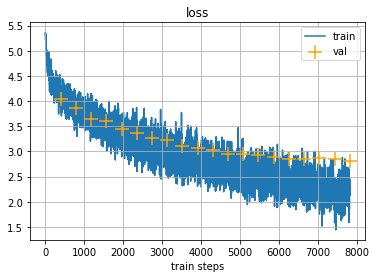

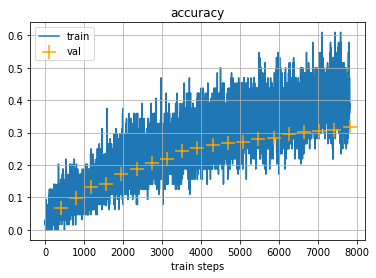

Epoch: 19, val loss: 2.8032228239357013, val accuracy: 0.3182225227355957
Epoch: 19, train loss: 2.2037763174842384, train accuracy: 0.40277335047721863
Epoch time: 12.811894655227661


In [11]:
trainer.train(n_epochs=20, batch_size=BATCH_SIZE, lr=1e-2, cuda=True, plot_history=plot_history, clear_output=clear_output, with_watermark=True)

In [12]:
trainer.predict_watermark() == trainer.get_watermark()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

Change outputs amount 

In [13]:
def fake_output_ones(layer, ones_num):
    prev_weights = layer.weight.data.detach().clone()
    prev_bias = layer.bias.data.detach().clone()
    new_layer = nn.Linear(layer.in_features, layer.out_features + ones_num)
    new_layer.weight.data = torch.cat([prev_weights, torch.zeros(ones_num, new_layer.in_features)])
    new_layer.bias.data = torch.cat([prev_bias, torch.ones(ones_num)])
    return new_layer

In [14]:
def inject_fake_matrix(layer, fake_tensor):
    prev_weights = layer.weight.data.detach().clone()
    prev_bias = layer.bias.data.detach().clone()
    new_layer = nn.Linear(layer.in_features + fake_tensor.shape[1], layer.out_features)
    print(new_layer.weight.data.shape)
    new_layer.weight.data = torch.cat([prev_weights, fake_tensor], dim=-1)
    new_layer.bias.data = prev_bias - fake_tensor.sum(dim=-1)
    return new_layer

In [15]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): LeakyReLU(negative_slope=0.1)
  (15): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (16

In [16]:
message = torch.bernoulli(torch.zeros(MESSAGE_SIZE) + 0.5)

In [17]:
from tqdm.notebook import tqdm

def encode(message, epochs=10**3, lr=1e-1, lambda_rand=0.1):
    message_size = message.view(-1).shape[0]
    R = torch.normal(torch.zeros(message_size, message_size), torch.ones(message_size, message_size))
    w = nn.Linear(message_size, 1, bias=False)
    opt = torch.optim.SGD(params=w.parameters(), lr=lr, weight_decay=1e-3)
    bar = tqdm(total=epochs)
    for e in range(epochs):
        opt.zero_grad()
        message_pred = w(R).view(-1) + torch.matmul(R, lambda_rand*torch.rand_like(message))
        loss = torch.nn.functional.binary_cross_entropy_with_logits(message_pred, message)
        loss.backward()
        opt.step()
        bar.set_postfix_str(s='loss {loss}'.format(loss=loss.item()))
        bar.update(1)
    return w.weight.data.detach().clone().view(-1), R

def decode(w, key):
    return (key.matmul(w) >= 0).to(torch.float32)

def get_message_accuracy(message_true, message_pred):
    return(message_true == message_pred).to(torch.float32).mean().item()

In [18]:
w, key = encode(message)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
decoded_message = decode(w, key)

In [20]:
get_message_accuracy(message, decoded_message)

1.0

In [21]:
fake_tensor = w.view(100, -1)

In [22]:
from copy import deepcopy

In [23]:
model = model.cpu()

In [24]:
model_encoded = deepcopy(model)

In [25]:
model_encoded[-4] = fake_output_ones(model_encoded[-4], fake_tensor.shape[-1])

In [26]:
model_encoded[-2] = inject_fake_matrix(model_encoded[-2], fake_tensor)

torch.Size([100, 65])


In [27]:
trainer.set_model(model)
loss, acc = map(np.mean, trainer.test(cuda=True))
trainer.set_model(model_encoded)
loss_encoded, acc_encoded = map(np.mean, trainer.test(cuda=True))
model = model.cpu()
model_encoded = model_encoded.cpu()

In [28]:
print(loss, loss_encoded)
print(acc, acc_encoded)

2.8032228239357013 2.8032228117403775
0.31822252 0.31822252


In [29]:
print(model_encoded[-2].weight.data[:, -1:].detach().clone().view(-1))
print(w)

tensor([-8.4829e-01,  4.8045e-02, -7.6903e-02, -4.4043e-01,  1.9126e-01,
        -9.5597e-01,  1.6619e-01, -1.3221e+00,  3.8042e-01, -5.1421e-01,
         1.3048e+00,  1.4894e-02,  1.6203e-01,  1.0688e-01, -1.1420e-01,
        -5.9673e-01,  1.1552e-01, -9.6879e-02,  1.9368e-02, -7.0102e-01,
        -9.1018e-01, -4.8202e-01, -2.3320e-01, -5.1092e-01,  5.9191e-01,
        -2.7800e-01,  9.3216e-01,  1.8102e-01,  6.8484e-01,  2.3009e-01,
         7.5774e-01, -1.4091e-02,  3.2498e-01, -1.6864e-01,  5.7899e-01,
         7.0943e-02,  4.6220e-01,  9.2222e-01, -7.2013e-01, -6.2910e-01,
        -3.1456e-01, -5.1017e-01,  1.0232e-01,  4.3798e-01, -2.5011e-01,
        -2.4037e-01,  3.0164e-01, -4.4896e-01, -2.6097e-01, -4.2863e-01,
        -1.0072e+00,  6.2007e-01,  6.0090e-01, -5.6791e-01, -8.2886e-02,
        -5.1386e-01, -1.1423e+00, -3.0666e-01,  3.2619e-02, -4.6110e-01,
         9.0570e-02, -3.1214e-02,  2.8092e-01,  4.2779e-01,  1.8850e-01,
        -2.3012e-01, -2.5296e-01,  6.1928e-01, -2.0

In [30]:
decoded_message = decode(model_encoded[-2].weight.data[:, -1:].detach().cpu().clone().view(-1), key)

In [31]:
get_message_accuracy(message, decoded_message)

1.0

In [32]:
trainer.set_model(model_encoded)

In [33]:
acc_message_our = [get_message_accuracy(message, decoded_message)]
acc_message_orig = [get_message_accuracy(trainer.get_watermark(), trainer.predict_watermark())]

In [34]:
print(acc_message_our)
print(acc_message_orig)

[1.0]
[1.0]


In [38]:
for e in range(10):
    trainer.train(n_epochs=1, batch_size=BATCH_SIZE, lr=1e-3, cuda=True)
    model_encoded = model_encoded.cpu()
    decoded_message = decode(model_encoded[-2].weight.data[:, -1:].detach().cpu().clone().view(-1), key)
    acc_message_our.append(get_message_accuracy(message, decoded_message))
    acc_message_orig.append(get_message_accuracy(trainer.get_watermark(), trainer.predict_watermark()))

Epoch 0 of 1
Epoch: 0, val loss: 2.8524273646152234, val accuracy: 0.35618606209754944
Epoch: 0, train loss: 1.5010793855428086, train accuracy: 0.570252537727356
Epoch time: 12.364414691925049
Epoch 0 of 1
Epoch: 0, val loss: 2.848509209540189, val accuracy: 0.35753676295280457
Epoch: 0, train loss: 1.485793542221684, train accuracy: 0.577038049697876
Epoch time: 12.002232074737549
Epoch 0 of 1
Epoch: 0, val loss: 2.851609523948806, val accuracy: 0.3546755313873291
Epoch: 0, train loss: 1.4700888062986877, train accuracy: 0.5828564763069153
Epoch time: 12.641972541809082
Epoch 0 of 1
Epoch: 0, val loss: 2.8931811953444617, val accuracy: 0.3555946350097656
Epoch: 0, train loss: 1.454446672173717, train accuracy: 0.5841192603111267
Epoch time: 12.535733222961426
Epoch 0 of 1
Epoch: 0, val loss: 2.893416163866477, val accuracy: 0.3542679250240326
Epoch: 0, train loss: 1.4386622510907594, train accuracy: 0.5891304612159729
Epoch time: 12.515419960021973
Epoch 0 of 1
Epoch: 0, val loss: 2.

In [39]:
print(acc_message_our)
print(acc_message_orig)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9900000095367432, 0.9900000095367432, 0.9900000095367432, 0.9800000190734863]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


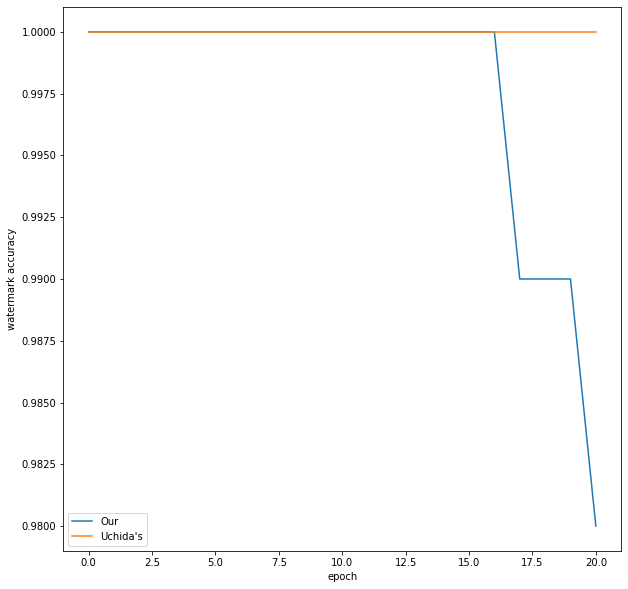

In [40]:
plt.figure(figsize=(10,10))
plt.plot(acc_message_our, label='Our')
plt.plot(acc_message_orig, label='Uchida\'s')
plt.xlabel('epoch')
plt.ylabel('watermark accuracy')
plt.legend()
plt.show()